In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#1 Data retireval $ inspection
# Load dataset
df = pd.read_csv("circles_binary_classification.csv")

# Inspect
print(df.head())
print(df.describe())


         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
                X1           X2       label
count  1000.000000  1000.000000  1000.00000
mean     -0.000448    -0.000804     0.50000
std       0.639837     0.641156     0.50025
min      -1.059502    -1.067768     0.00000
25%      -0.619251    -0.612176     0.00000
50%       0.008762    -0.003949     0.50000
75%       0.621933     0.624822     1.00000
max       1.033712     1.036004     1.00000


In [24]:
# Data cleaning & feature design

# Minimal cleaning
df.columns = df.columns.str.strip()
df = df.drop_duplicates()
df = df.dropna(subset=["X1", "X2", "label"])

# Ensure numeric
df["X1"] = pd.to_numeric(df["X1"], errors="coerce")
df["X2"] = pd.to_numeric(df["X2"], errors="coerce")
df["label"] = pd.to_numeric(df["label"], errors="coerce")
df = df.dropna(subset=["X1", "X2", "label"])

# Features and target
X = df[["X1", "X2"]].values
y = df["label"].values

# Convert to NumPy
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)


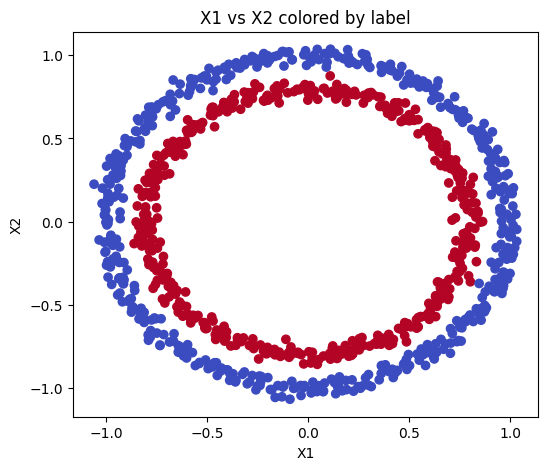

In [25]:
#Visualize data

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y.squeeze(), cmap="coolwarm")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("X1 vs X2 colored by label")
plt.show()

In [26]:
# Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [27]:
# Device & dtype

device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [28]:
# Implement baseline models

class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2,5),
            nn.Linear(5,1)
        )
    def forward(self, x):
        return self.layer_stack(x)

class ModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2,15),
            nn.Linear(15,15),
            nn.Linear(15,1)
        )
    def forward(self, x):
        return self.layer_stack(x)

class ModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(2,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.ReLU(),
            nn.Linear(10,1)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [29]:
# Loss, optimizer, metrics

loss_fn = nn.BCEWithLogitsLoss()

def accuracy_fn(y_true, y_logits):
    y_pred = torch.round(torch.sigmoid(y_logits))
    correct = (y_pred == y_true).sum().item()
    return correct / len(y_true)

In [30]:
# Training loop

def train_and_test_loop(model, epochs):
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
    
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        y_logits = model(X_train)
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_train, y_logits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_logits)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        train_accs.append(acc)
        test_accs.append(test_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | "
                  f"Train Loss {loss:.4f} | Train Acc {acc:.4f} | "
                  f"Test Loss {test_loss:.4f} | Test Acc {test_acc:.4f}")

    return train_losses, test_losses, train_accs, test_accs

In [31]:
# V0
model_v0 = ModelV0().to(device)
train_losses_v0, test_losses_v0, train_accs_v0, test_accs_v0 = train_and_test_loop(model_v0, 100)

# V1
model_v1 = ModelV1().to(device)
train_losses_v1, test_losses_v1, train_accs_v1, test_accs_v1 = train_and_test_loop(model_v1, 1000)

# V2
model_v2 = ModelV2().to(device)
train_losses_v2, test_losses_v2, train_accs_v2, test_accs_v2 = train_and_test_loop(model_v2, 1000)

Epoch 0 | Train Loss 0.7334 | Train Acc 0.5000 | Test Loss 0.7304 | Test Acc 0.5000
Epoch 10 | Train Loss 0.7124 | Train Acc 0.4963 | Test Loss 0.7121 | Test Acc 0.4900
Epoch 20 | Train Loss 0.7031 | Train Acc 0.4075 | Test Loss 0.7040 | Test Acc 0.4000
Epoch 30 | Train Loss 0.6986 | Train Acc 0.4725 | Test Loss 0.7001 | Test Acc 0.4250
Epoch 40 | Train Loss 0.6963 | Train Acc 0.4800 | Test Loss 0.6981 | Test Acc 0.4400
Epoch 50 | Train Loss 0.6950 | Train Acc 0.4938 | Test Loss 0.6970 | Test Acc 0.4800
Epoch 60 | Train Loss 0.6943 | Train Acc 0.4838 | Test Loss 0.6964 | Test Acc 0.5050
Epoch 70 | Train Loss 0.6939 | Train Acc 0.4863 | Test Loss 0.6960 | Test Acc 0.5050
Epoch 80 | Train Loss 0.6936 | Train Acc 0.4913 | Test Loss 0.6957 | Test Acc 0.4950
Epoch 90 | Train Loss 0.6934 | Train Acc 0.4963 | Test Loss 0.6956 | Test Acc 0.4900
Epoch 0 | Train Loss 0.7202 | Train Acc 0.5000 | Test Loss 0.7169 | Test Acc 0.5000
Epoch 10 | Train Loss 0.6996 | Train Acc 0.4575 | Test Loss 0.7001 

In [32]:
# Predictions & evaluation

# Untrained
temp_model = ModelV2().to(device)
with torch.inference_mode():
    print("Untrained predictions:", torch.sigmoid(temp_model(X_test[:5])))

# Trained
with torch.inference_mode():
    print("Trained predictions:", torch.sigmoid(model_v2(X_test[:5])))

Untrained predictions: tensor([[0.4761],
        [0.4774],
        [0.4820],
        [0.4763],
        [0.4849]])
Trained predictions: tensor([[0.9938],
        [0.0474],
        [0.9936],
        [0.0117],
        [0.9078]])


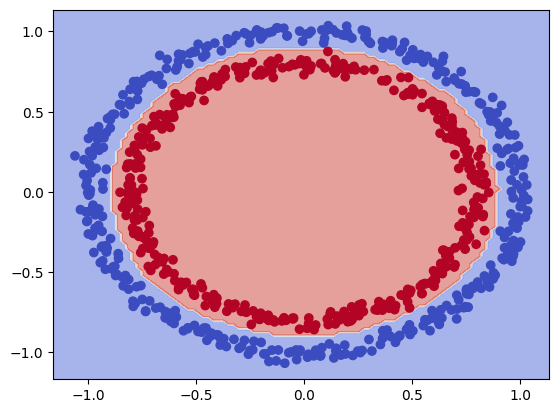

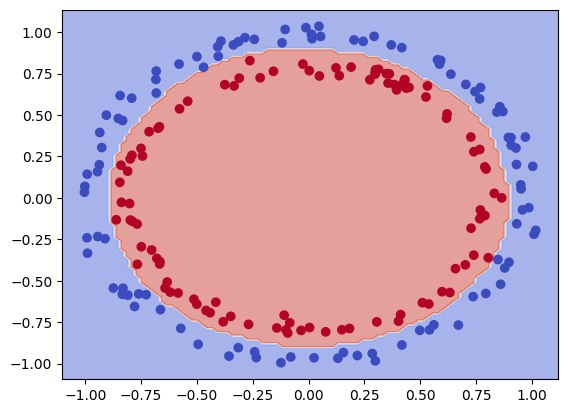

In [33]:
#Decision boundary

def plot_decision_boundary(model, X, y):
    model.eval()
    x_min, x_max = X[:,0].min()-0.1, X[:,0].max()+0.1
    y_min, y_max = X[:,1].min()-0.1, X[:,1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    
    with torch.inference_mode():
        logits = model(grid)
        preds = torch.round(torch.sigmoid(logits))
    
    preds = preds.cpu().numpy().reshape(xx.shape)
    
    plt.contourf(xx, yy, preds, alpha=0.5, cmap="coolwarm")
    plt.scatter(X[:,0].cpu(), X[:,1].cpu(), c=y.cpu(), cmap="coolwarm")
    plt.show()

plot_decision_boundary(model_v2, X_train, y_train)
plot_decision_boundary(model_v2, X_test, y_test)

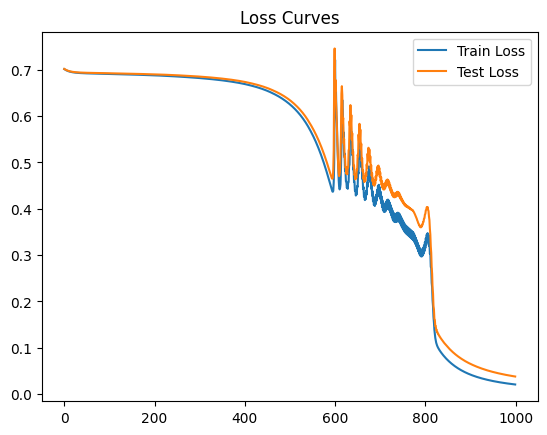

In [34]:
# Loss curve

plt.plot(train_losses_v2, label="Train Loss")
plt.plot(test_losses_v2, label="Test Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

🔹 13. Discussion & Conclusion (Compulsory)

🔍 Observations

- ModelV0 (Linear) struggles if data is non-linearly separable.

- ModelV1 (Deeper Linear) still limited because no activation → still linear transformation.

- ModelV2 (ReLU) captures non-linear boundaries → significantly better performance.

- BCEWithLogitsLoss ensures numerical stability.

-  between experiments prevents weight leakage.

📊 Key Insight

Without activation functions, deeper networks are still equivalent to a single linear transformation. Non-linearity (ReLU) is essential for complex decision boundaries.

🏁 Conclusion

- For simple linear datasets → ModelV0 sufficient.

- For non-linear data → ModelV2 clearly superior.

- Proper device handling makes code GPU-ready.

- Training curves help detect underfitting/overfitting.